In [2]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f

In [3]:
class PyCipio:
    def __init__(self, data, x_col, y_col):
        
        data = data.rename(
            columns = {x_col: "date",
                      y_col: "y"})
        
        self.data = data
        self.data["time"] = np.arange(0, len(data), 1)
        
        #should be made flexible for more groups, but currently made for one group.
        self.time_true = self.data["time"].values 
        self.data["idx_true"] = np.zeros(len(data), dtype = int)
        
        ### should be good
        self.n_idx = len(np.unique(idx_true))
        
    def scale_down(self, x):
        minimum = self.time_true.min()
        maximum = self.time_true.max()
        
        return (x - minimum) / (maximum - minimum)
    
    def scale_up(self, x):
        minimum = self.time_true.min()
        maximum = self.time_true.max()
        
        return (x + minimum) * (maximum - minimum)
    
    def add_seasonal_component(self, name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled):
    
        p = pm.Beta(name, 
                    mu = mu, 
                    sd = sd, 
                    shape = shape)

        ### TO REMOVE RHATS, ORDER P
        ## throws insane warnings, but does run

        ### seems like if you just want to remove the warnings, you can go:
        # theano.config.compute_test_value = "warn"

        ##theano says: Hint: relax the tolerance by setting tensor__cmp_sloppy=1
          #or even tensor__cmp_sloppy=2 for less-strict comparison

        ### MOREOVER: much slower

        #p = pm.Beta(name, 
        #        mu = np.linspace(0.05, 0.6, shape), ## How the fuck do you set these flexibly? 
        #        sd = sd, 
        #        shape = shape, 
        #        transform = pm.distributions.transforms.ordered) #experimental fix for getting ordered variables

        ### SO! Above works, gives quite good predictions, but I am not sure that is what we want.
        # Now that p comes from a beta, it won't be able to find duplicates solutions from having a negative period.


        period_x = 2*np.pi*np.arange(1, n_components+1)
        period_stack_x = np.stack([period_x for i in range(shape)])
        period_scaled_x = period_stack_x.T / p
        x = tt.reshape(period_scaled_x[:, :, None] * time_scaled, (n_components, shape*len(time_scaled)))
        x_waves = tt.concatenate((tt.cos(x), tt.sin(x)), axis = 0)

        ### weight beta
        #beta_waves = pm.Normal(name_beta, 
        #                       mu = 0, 
        #                       sd = beta_sd, 
        #                       shape = (2*n_components, shape)) 

        ## seems like you have to have this linspace in there for it to work. Need to try without.
        # right now, the whole thing throws maaaassive errors. But! Much faster than when we did it for p.

        beta_waves = pm.Normal(name_beta, 
                               mu = np.linspace(0, 0.1, shape),
                               sd = beta_sd, 
                               shape = (2*n_components, shape),
                               transform = pm.distributions.transforms.Ordered()) ## does this make a difference??

        ### flatten waves
        lst = []
        index_first = 0
        index_second = len(time_scaled)
        for i in range(shape): 
            tmp = pm.math.dot(x_waves.T[index_first:index_second, :], beta_waves[:, i])
            lst.append(tmp)
            index_first += len(time_scaled)
            index_second += len(time_scaled) 
        stacked = tt.stack(lst)
        x_flat = tt.flatten(stacked)

        return (beta_waves, x_waves, x_flat)
    
        
    

In [4]:
Pc= PyCipio(pd.read_csv("../data/archive/Alcohol_Sales.csv"), x_col = "DATE", y_col = "S4248SM144NCEN")

NameError: name 'idx_true' is not defined

In [79]:
data = pd.read_csv("../data/archive/Alcohol_Sales.csv")
data = data.rename(
            columns = {"S4248SM144NCEN": "y",
                      "DATE": "date"})

In [80]:
time = np.arange(0, len(data), 1) 
#quirk of the setup is to have time_true as well
time_true = time
idx_true = np.zeros(len(data), dtype = int)
y_true = data["y"].values

In [81]:
n_idx = len(np.unique(idx_true))

In [82]:
## week 
n_week_components = 4
p_week_mu = (5 - time_true.min()) / (time_true.max() - time_true.min())
p_week_sd = (4 - time_true.min()) / (time_true.max() - time_true.min())
beta_week_sd = 0.2

## month
n_month_components = 6
p_month_mu = (12 - time_true.min()) / (time_true.max() - time_true.min())
p_month_sd = (3 - time_true.min()) / (time_true.max() - time_true.min())
beta_month_sd = 0.3

In [83]:
def seasonal_component(name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled):
    
    p = pm.Beta(name, 
                mu = mu, 
                sd = sd, 
                shape = shape)
    
    ### TO REMOVE RHATS, ORDER P
    ## throws insane warnings, but does run
    
    ### seems like if you just want to remove the warnings, you can go:
    # theano.config.compute_test_value = "warn"
    
    ##theano says: Hint: relax the tolerance by setting tensor__cmp_sloppy=1
      #or even tensor__cmp_sloppy=2 for less-strict comparison
        
    ### MOREOVER: much slower
    
    #p = pm.Beta(name, 
    #        mu = np.linspace(0.05, 0.6, shape), ## How the fuck do you set these flexibly? 
    #        sd = sd, 
    #        shape = shape, 
    #        transform = pm.distributions.transforms.ordered) #experimental fix for getting ordered variables
    
    ### SO! Above works, gives quite good predictions, but I am not sure that is what we want.
    # Now that p comes from a beta, it won't be able to find duplicates solutions from having a negative period.
    
    length_shared = time_shared.shape.eval()[0]
    
    period_x = 2*np.pi*np.arange(1, n_components+1)
    period_stack_x = np.stack([period_x for i in range(shape)])
    period_scaled_x = period_stack_x.T / p
    x = tt.reshape(period_scaled_x[:, :, None] * time_shared, (n_components, shape*length_shared))
    x_waves = tt.concatenate((tt.cos(x), tt.sin(x)), axis = 0)
    
    ### weight beta
    #beta_waves = pm.Normal(name_beta, 
    #                       mu = 0, 
    #                       sd = beta_sd, 
    #                       shape = (2*n_components, shape)) 
    
    ## seems like you have to have this linspace in there for it to work. Need to try without.
    # right now, the whole thing throws maaaassive errors. But! Much faster than when we did it for p.
    
    beta_waves = pm.Normal(name_beta, 
                           mu = np.linspace(0, 0.1, shape),
                           sd = beta_sd, 
                           shape = (2*n_components, shape))
                           #transform = pm.distributions.transforms.Ordered()) ## does this make a difference??
    
    ### flatten waves
    lst = []
    index_first = 0
    index_second = length_shared
    for i in range(shape): 
        tmp = pm.math.dot(x_waves.T[index_first:index_second, :], beta_waves[:, i])
        lst.append(tmp)
        index_first += length_shared
        index_second += length_shared 
    stacked = tt.stack(lst)
    x_flat = tt.flatten(stacked)
    
    return (beta_waves, x_waves, x_flat)

In [84]:
def seasonal_component(name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled):
    
    p = pm.Beta(name, 
                mu = mu, 
                sd = sd, 
                shape = shape)
    
    ### TO REMOVE RHATS, ORDER P
    ## throws insane warnings, but does run
    
    ### seems like if you just want to remove the warnings, you can go:
    # theano.config.compute_test_value = "warn"
    
    ##theano says: Hint: relax the tolerance by setting tensor__cmp_sloppy=1
      #or even tensor__cmp_sloppy=2 for less-strict comparison
        
    ### MOREOVER: much slower
    
    #p = pm.Beta(name, 
    #        mu = np.linspace(0.05, 0.6, shape), ## How the fuck do you set these flexibly? 
    #        sd = sd, 
    #        shape = shape, 
    #        transform = pm.distributions.transforms.ordered) #experimental fix for getting ordered variables
    
    ### SO! Above works, gives quite good predictions, but I am not sure that is what we want.
    # Now that p comes from a beta, it won't be able to find duplicates solutions from having a negative period.
    
    #length_shared = time_shared.shape.eval()[0]
    
    period_x = 2*np.pi*np.arange(1, n_components+1)
    period_stack_x = np.stack([period_x for i in range(shape)])
    period_scaled_x = period_stack_x.T / p
    x = tt.reshape(period_scaled_x[:, :, None] * time_shared, (n_components, shape*length_shared))
    x_waves = tt.concatenate((tt.cos(x), tt.sin(x)), axis = 0)
    
    ### weight beta
    #beta_waves = pm.Normal(name_beta, 
    #                       mu = 0, 
    #                       sd = beta_sd, 
    #                       shape = (2*n_components, shape)) 
    
    ## seems like you have to have this linspace in there for it to work. Need to try without.
    # right now, the whole thing throws maaaassive errors. But! Much faster than when we did it for p.
    
    beta_waves = pm.Normal(name_beta, 
                           mu = 0,
                           sd = beta_sd, 
                           shape = (2*n_components, shape))
                           #transform = pm.distributions.transforms.Ordered()) ## does this make a difference??
    
    ### flatten waves
    lst = []
    index_first = 0
    index_second = length_shared
    for i in range(shape): 
        tmp = pm.math.dot(x_waves.T[index_first:index_second, :], beta_waves[:, i])
        lst.append(tmp)
        index_first += length_shared
        index_second += length_shared
    stacked = tt.stack(lst)
    x_flat = tt.flatten(stacked)
    
    return (beta_waves, x_waves, x_flat)

In [85]:
## scale stuff
time_true_scaled = (time_true - time_true.min()) / (time_true.max() - time_true.min())
time_scaled = (time - time.min()) / (time.max() - time.min())
# each individually?
y_true_scaled = (y_true - y_true.min()) / (y_true.max() - y_true.min())

In [87]:
### MODULAR APPROACH:

with pm.Model() as m0: 
    
    # shared 
    t_shared = pm.Data('t_shared', time_true_scaled)
    time_shared = pm.Data("time_shared", time_scaled)
    idx_shared = pm.Data('idx_shared', idx_true)
    length_shared = pm.Data("length_shared", np.array(len(time_scaled)))
    
    # prepare fourier week
    #seasonal_component(name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled)
    beta_week_waves, x_week_waves, week_flat = seasonal_component(name = "p_week",
                                                       name_beta = "beta_week_waves",
                                                       mu = p_week_mu,
                                                       sd = p_week_sd,
                                                       beta_sd = beta_week_sd,
                                                       n_components = n_week_components,
                                                       shape = n_idx,
                                                       time_scaled = time_scaled)
    
    beta_month_waves, x_month_waves, month_flat = seasonal_component(name = "p_month",
                                                       name_beta = "beta_month_waves",
                                                       mu = p_month_mu,
                                                       sd = p_month_sd,
                                                       beta_sd = beta_month_sd,
                                                       n_components = n_month_components,
                                                       shape = n_idx,
                                                       time_scaled = time_scaled)
    
    # other priors
    beta_line = pm.Normal('beta_line', mu = 0, sd = 0.3, shape = n_idx)
    alpha = pm.Normal('alpha', mu = 0.5, sd = 0.3, shape = n_idx)

    mu = alpha[idx_shared] + beta_line[idx_shared] * t_shared + week_flat * t_shared + month_flat * t_shared
    
    # sigma 
    sigma = pm.Exponential('sigma', 1)
    
    # likelihood 
    y_pred = pm.Normal('y_pred', 
                       mu = mu,
                       sd = sigma,
                       observed = y_true_scaled)

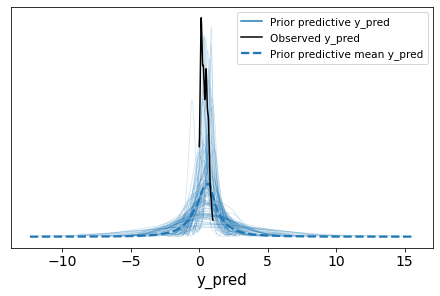

In [88]:
## prior sampling 
with m0:
    prior_pred = pm.sample_prior_predictive(100) # like setting this low. 
    m0_idata = az.from_pymc3(prior=prior_pred)

az.plot_ppc(m0_idata, group="prior")

## sample everything 
# convenience function 
def sample_mod(
    model, 
    posterior_draws = 1000, 
    post_pred_draws = 1000,
    prior_pred_draws = 500):
    
    with model: 
        trace = pm.sample(
            return_inferencedata = False, 
            draws = posterior_draws,
            target_accept = .95) # tuning!
        post_pred = pm.sample_posterior_predictive(trace, samples = post_pred_draws)
        prior_pred = pm.sample_prior_predictive(samples = prior_pred_draws)
        m_idata = az.from_pymc3(trace = trace, posterior_predictive=post_pred, prior=prior_pred)
    
    return m_idata

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_line, beta_month_waves, p_month, beta_week_waves, p_week]
INFO:pymc3:NUTS: [sigma, alpha, beta_line, beta_month_waves, p_month, beta_week_waves, p_week]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 790 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 790 seconds.
The acceptance probability does not match the target. It is 0.8699459040964208, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


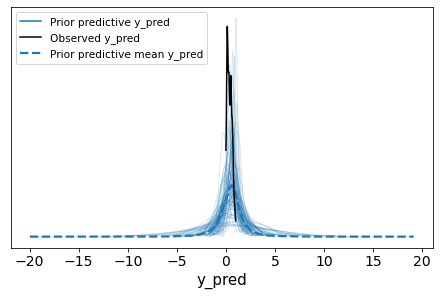

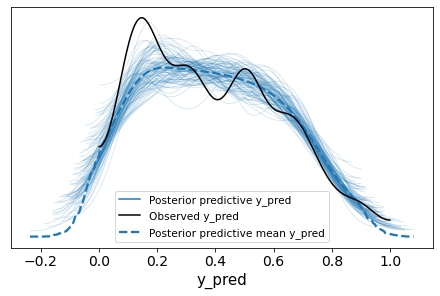

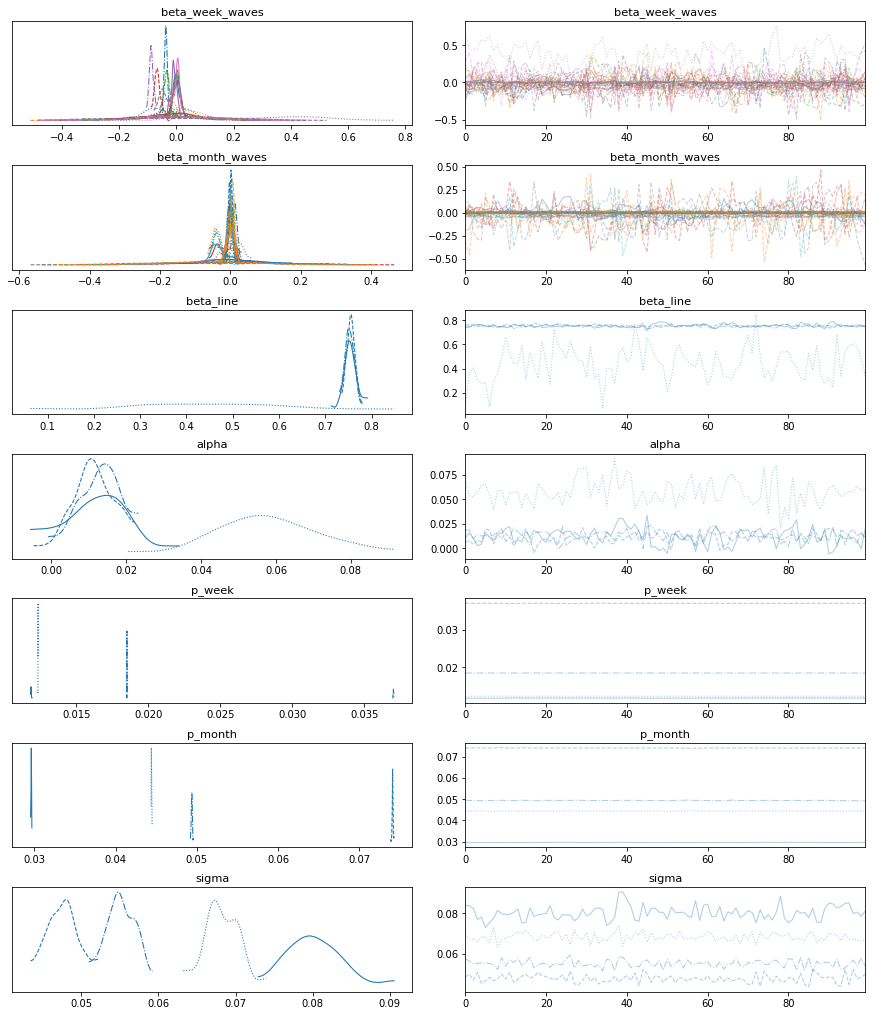

In [89]:
m0_idata = sample_mod(m0, posterior_draws = 100)

## plot checks 
az.plot_ppc(m0_idata, num_pp_samples = 100, group = "prior")
az.plot_ppc(m0_idata, num_pp_samples = 100)

## plot trace
az.plot_trace(m0_idata)

## fit to data
m_pred = m0_idata.posterior_predictive.mean(axis = 1)
m_pred_std = m_pred.std(axis = 0)
m_pred = m_pred.mean(axis = 0)

### Considerations for r-hat
It seems like the different chains are reliably fixing on different p's, and being very certain that the actual value of p is that value. Fixes could be to set the sd very low, but then we are not really estimating p. It seems like the ordering doesn't really help that much with that. Maybe it is not the right variable that we are ordering. Need to check that it actually does what we want. 

In [61]:
y_hat = m0_idata["posterior_predictive"]["y_pred"].data

In [62]:
y_hat = y_hat[0]## quick way of only having one group, should do another thing to make it general. 

In [63]:
y_hat_mean = y_hat.mean(axis = 0)
y_hat_std = y_hat.std(axis = 0)

In [64]:
data["date"] = pd.to_datetime(data["date"])

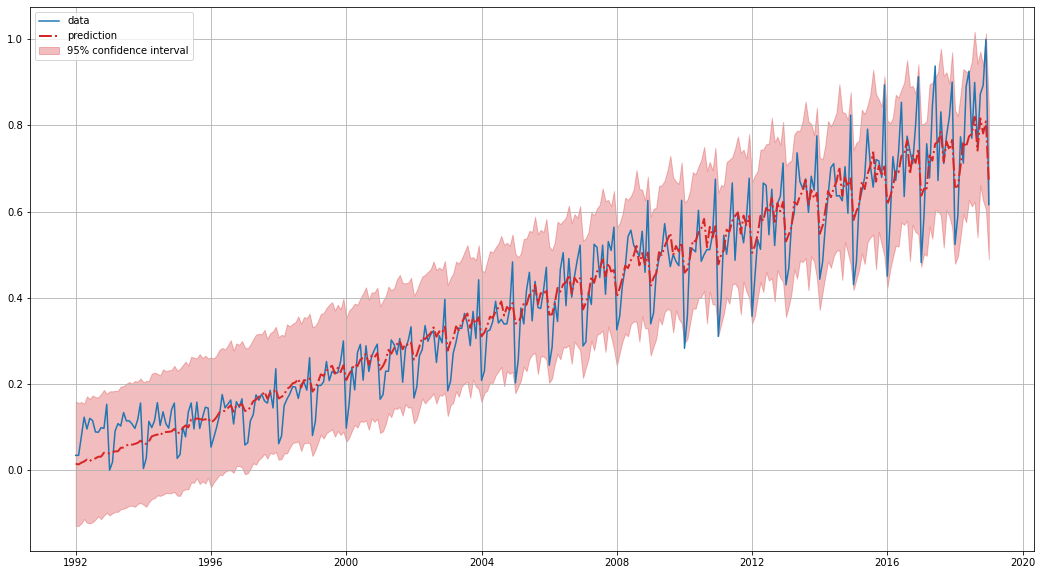

In [65]:
# plot them 
fig, ax = plt.subplots(figsize = (18, 10))
ax.plot(data["date"].values, y_true_scaled, label = "data", linewidth = 1.5)
ax.plot(data["date"].values, y_hat_mean, ls="-.", label = "prediction", color = "C3", linewidth = 2)
ax.fill_between(data["date"].values, 
                y_hat_mean -1.96 * y_hat_std, 
                m_pred["y_pred"] + 1.96 * y_hat_std, 
                alpha=0.3, 
                label = "95% confidence interval",
                color = "C3")
ax.grid()
ax.legend()

worse than with p fixed.

In [90]:
data

,date,y
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [91]:
time_test = np.arange(len(data), len(data)+50, 1) # 325
time_test = (time_test - time_true.min()) / (time_true.max() - time_true.min())

In [92]:
len(time_test)

50

In [93]:
len(time_true)

325

In [94]:
idx_test = np.zeros(len(time_test), dtype = int)

In [95]:
with m0:
    pm.set_data({"t_shared": time_test})
    pm.set_data({"time_shared": time_test})
    pm.set_data({"idx_shared": idx_test})
    pm.set_data({"length_shared": np.array(len(time_test))})
    m_new_pred = pm.fast_sample_posterior_predictive(
        m0_idata.posterior
    )

In [96]:
m_new_pred["y_pred"].shape

(400, 50)

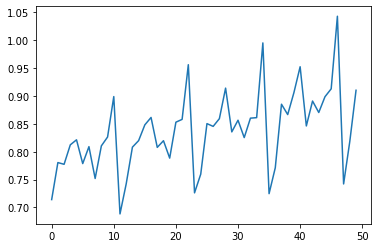

In [99]:
plt.plot(m_new_pred["y_pred"].mean(axis = 0))